## Testing: Some 1d Examples


In [1]:
# load modules with code for adaptive solvers
include("adaptive-extrapolation-Deuflhard.jl") # implementation based on Deuflhard's ideas
include("adapative-extrapolation-Hairer&Wanner.jl") # implementation based on Hairer and Wanners's ideas
using Plots;

In [2]:
# define the problems
examples1d = [
    Dict(
        "rhs" => (t,x) -> x,
        "sol" => t -> exp(t),
        "misc" => (0.0, [1.0], 4.0), # t_0, x_0, T
        "title" => "Test Equation"
    ),
    Dict(
        "rhs" => (t,x) -> x,
        "sol" => t -> exp(t),
        "misc" => (1.0, [exp(1.0)], -3.0), # t_0, x_0, T
        "title" => "Test Equation Backward"
    ),
    Dict(
        "rhs" => (t,x) -> x.*cos.(t),
        "sol" => t -> exp.(sin.(t)),
        "misc" => (0.0, [1.0], 4*pi), # t_0, x_0, T
        "title" => "Oscillatory Problem"
    )
];


In [3]:
# a custom function for the plots
function solutionPlot(n; showSolution::Bool = true, legendPosition = :topleft)
    plt=plot()
    approximation = examples1d[n]["approximation"]
    plot!(plt,
        title = examples1d[n]["title"],
        legend = legendPosition,
        xlabel = "t",
        ylabel = "x"
        )

    for (name, data) in approximation
        Δ = data[1]
        xΔ = (data[2])
        plot!(plt,Δ,xΔ',
            label = name*" $(length(Δ) -1) steps",
            xlims = (-1, 1) .+ extrema(Δ),
            ylims = (-1, 1) .+extrema(xΔ[:]),
            markershape = :circle
            )
    end
    if showSolution
        t₀,_,T =  examples1d[n]["misc"]
        sol =  examples1d[n]["sol"]
        tt = min(t₀,T):0.1:max(t₀,T)
        xx = sol.(tt)
        plot!(plt,tt,xx,linewidth = 2,label = "Solution")
    end
    return plt
end;

In [4]:
# initialize solvers
N_max = 10
solverHW = AdaptiveExtrapolationHW.solver(N_max,"Harmonic")
solverD = AdaptiveExtrapolationD.solver(N_max,"Harmonic");

In [5]:
# computations
for (n,problem) in enumerate(examples1d)
    f = problem["rhs"]
    t₀, x₀, tEnd = problem["misc"]
    approximation = Dict(
        "D." => solverD(f,x₀,t₀,tEnd),
        "H.&W." => solverHW(f,x₀,t₀,tEnd)
    )
    problem["approximation"] = approximation
end;

### Plots of 1d examples

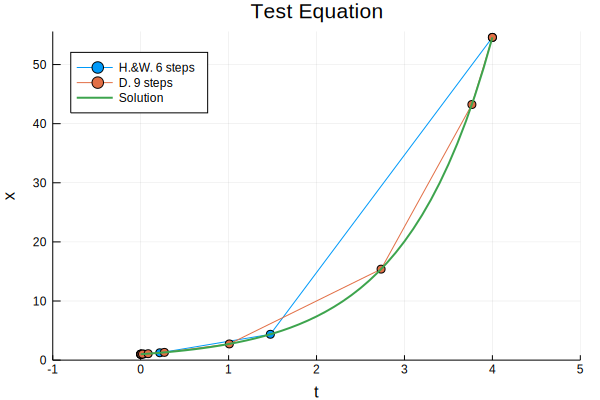

In [6]:
solutionPlot(1)

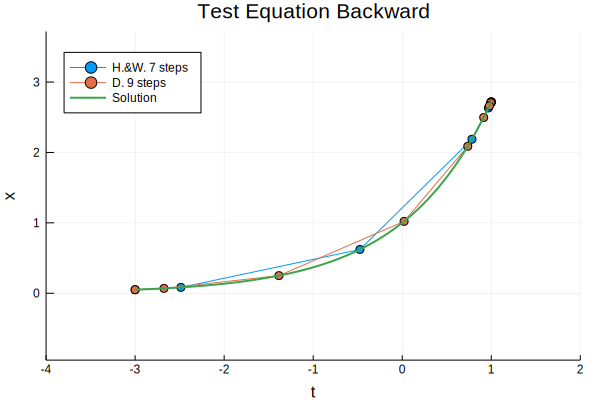

In [7]:
solutionPlot(2)

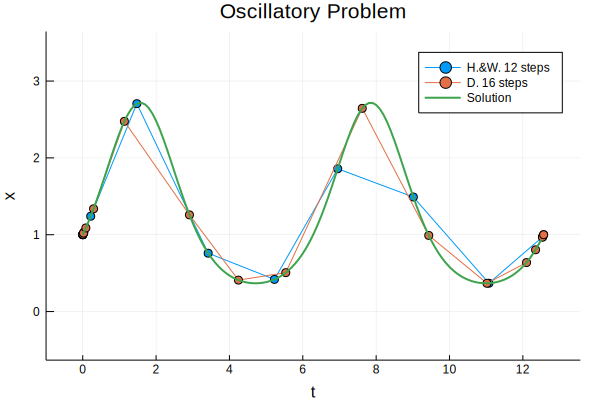

In [8]:
solutionPlot(3;legendPosition = :topright)

## A Complex Example

In [9]:
# complex IVP
fComplex(t,x) =sin(t)*exp(t*im)*x
t₀ =0.0
x₀ = [1.0+0im]
tEnd = 4pi
# compute approximation
(ΔD,zΔD,_) = solverD(fComplex,x₀,t₀,tEnd)
(ΔHW,zΔHW,_)=solverHW(fComplex,x₀,t₀,tEnd);

In [10]:
# compute exact solution
solComplex(t) = exp(1/4 - exp((2*im)*t)/4 + (im/2)*t)
tt = t₀:0.05:tEnd
zz = solComplex.(tt);

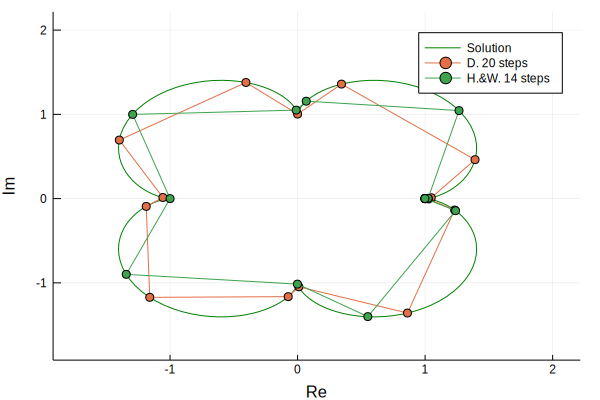

In [11]:
# plot results
pltComplex = plot(xlabel = "Re", ylabel = "Im", lims=[-1.8,2.1])
plot!(real(zz),imag(zz), color = :green, linewidth = 1, label = "Solution" )
plot!(pltComplex,real(zΔD)',imag(zΔD)', markershape = :circle, label = "D. $(length(real(zΔD))-1) steps")
plot!(pltComplex,real(zΔHW)',imag(zΔHW)', markershape = :circle, label = "H.&W. $(length(real(zΔHW))-1) steps")

## Documentation

Both adaptive solver have a documentation, here is the last example of this notebook:

In [12]:
?AdaptiveExtrapolationD.solver

```
(Δ,Δx,statisitic) = (mySolver::solver)(f::Function, x₀::Vector{T}, t₀::S, tEnd::S; <options>)
    where {T<:Number,S<:AbstractFloat}
```

Computes the grid function `xΔ` on the grid `Δ` approximating the solution of the initial value problem

```
    x′ = f(t,x),  x(t₀) = x₀
```

on the interval `[t₀,tEnd]` (or `[tEnd,t₀]` if `tEnd < t₀`). The integrator is the extrapolated explicit midpoint rule. The algorithm adaptively controls stepsize and extrapolation order in the line of thought of Deuflhard. Note that `solver` is a callable instance of the `struct solver`.

---

## Initialize `solver`

```
solver(N::Integer, sequence::String)
```

Initializes and returns the an instance of `solver`. `N ≧ 1` is the maximal order of extrapolation. `sequence` specifies the subdividing sequence used. The options are

  * `Harmonic`, that is `1, 2, 3, 4, 5, 6,...`
  * `Romberg`, that is `1, 2, 4, 8, 16, 32,...`
  * `Bulirsch`, that is `1, 2, 3, 4, 6, 8,...`

The structure contains all quantities for the adaptive extrapolation of the the explicit midpoint rule for all orders in `1:N` that can be tabulated before the actual computation . These are the *subdividing sequence* and the *weights* for the extrapolation based on the first barycentric formula.

---

## Options

The following options can be passed as keyword arguments.

  * `tol::S > 0` is tolerance used for accuracy check. Default is `1e-3`.
  * `relativeScaling::Vector{S}` and `absoluteScaling::Vector{S}` are vectors of the same length as `x₀`   containing no negative elements.   Default (in every component) is `relativeScaling[i] = 1.0` and `absoluteScaling[i] = 1e-3`.   The accuracy check is passed iff the estimated error satisfies in every component:

    ```
      |relativeError[i]| ≦ relativeScaling[i]⋅tol & |absoluteError[i]| ≦ absoluteScaling[i]⋅tol
    ```
  * `firstGuessStepsize::S` is the length of the first step. Its modulus must be greater than   `eps(S)` Default is `1e-3`.
  * `maximalSteplength::S > 0` is the maximal absolute stepsize used for the integration. Default is `Inf`.
  * `minimalStepsizeScaling::S` and `maximalStepsizeScaling::S` are safety factors for the stepsize   selection. Default are `0.25` and `4.0`. The new stepsize satisfies:

    ```
       0 ≦ minimalStepsizeScaling ≦ newStepsize / oldStepsize ≦ maximalStepsizeScaling
    ```
  * `safetyStepsizeSelection::S>0`. Use `safetyStepsizeSelection⋅tol` instead of `tol`. Default is `0.25`.
  * `minimumOrder::Int64 ≧ 1` and `maximumOrder::Int64 ≦ N` are the minimal and maximal order of extrapolation for the integration (`N` is the number that has been passed to the constructor). Default are `1` and `N`.
  * `firstGuessOrder::Int64` is the extrapolation order for the first step. It must satisfy   `minimumOrder ≦ firstGuessOrder ≦ maximumOrder`. Default is `round(Int64,(maximumOrder-minimumOrder)/2)`.
  * `maximumReduction::Int64` is the upper bound of the number of successive reductions allowed per step.   Exceeding this boundary leads to ending the integration prematurely (`Δ[end] ≠ tEnd`). Default is `10`.
  * `maximumSteps::Int64 ≧ 0` is the maximal length of the array `Δ`. Exceeding this boundary leads to   ending the integration prematurely (`Δ[end] ≠ tEnd`). Default is `10 000`.
  * `rescaleWeights::Bool` If `true` Lagrange interpolation is used otherwise the frist barycentric fromula. Default is `false`
  * `detailedStatistics::Bool` flag for the content of `statisitic`. Default is `false`

      * `true`: `statisitic[:,i]` contains [extrapolation order; stepsize; number of `f`-evaluations;   number of reductions] for the ith step.
      * `false`: `statisitic` contains [total number of evaluations of the right side `f`, total number of reductions].
